<a href="https://colab.research.google.com/github/restrepo/anomaly/blob/main/Type_II_Dirac_Seesaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solutions for effective Dirac neutrino masses from an Abelian Gauge Symmetry with massive chiral singlet fermions
For details see [arXiv:2108.05907](https://arxiv.org/pdf/2108.05907), Sec. 3.2

## Data Scheme
![img](https://raw.githubusercontent.com/restrepo/anomaly/main/schema.svg)

In [1]:
import pandas as pd
import numpy as np
import itertools

In [2]:
pd.set_option('display.max_colwidth',500)

### Load full solutions

In [3]:
ds=pd.read_json('https://github.com/restrepo/anomaly/raw/main/solutions.json.gz')
ds.shape

(390074, 5)

## Filter two set of repeated charges
with one of them repeated 3 times
$$(\nu,\nu[,\nu],\psi_1,\psi_2,\cdots)$$


In [4]:
#at least one set of repeated numbers
dsp=ds[ds['solution'].apply(lambda l: len(l)-len(set(l))>0)].reset_index(drop=True)
dsp.shape

(280959, 5)

Some reordering

In [5]:
dsp['nmax']=dsp['solution'].apply(lambda l: map(abs,l)).apply(max)
dsp=dsp.sort_values(['n','nmax']).reset_index(drop=True)
dsp2=dsp.copy()
#Show the first and last one solutions
dsp#.iloc[[0,1,2,-1]]

,l,k,solution,gcd,n,nmax
0,"[-1, -2]","[-1, 2]","[1, 1, 1, -4, -4, 5]",1,6,5
1,"[-1, 1]","[-2, 0]","[1, -2, -3, 5, 5, -6]",1,6,6
2,"[0, 1]","[-1, -3, 1]","[1, 1, 5, -9, -9, 11]",2,6,11
3,"[1, -2]","[-4, 1]","[1, -4, -4, 9, 9, -11]",3,6,11
4,"[-2, -1]","[-2, -3]","[2, 2, 3, -8, -12, 13]",1,6,13
...,...,...,...,...,...,...
280954,"[-2, -3, -1, 3, 2]","[-1, 3, 1, -1, -3]","[1, 2, -10, 12, 19, 19, -23, -24, -30, -30, 32, 32]",2,12,32
280955,"[-1, -2, 0, 3, 2]","[-1, 3, 1, -1, -2]","[1, 1, 1, 1, 8, -12, -19, 20, 21, -23, -31, 32]",1,12,32
280956,"[-1, 2, -3, -2, -3]","[-1, 3, 2, -2, -1]","[1, 2, 2, 4, 5, -7, -7, -9, -11, 25, 27, -32]",2,12,32
280957,"[-1, 3, -2, 2, -2]","[-1, 3, 2, -1, -2]","[1, 3, 4, 8, -9, -9, -12, 19, 19, -28, -28, 32]",1,12,32


## 1. Check effective conditions

$$ \nu+m+\delta s=0$$

$$ \psi_i+\psi_j=|s|$$

In [6]:
def get_massless(l,s,rank=True):
    if len(l)==0:
        return []
    elif len(l)==1:
        mssls=[(l[0],l[0])]
    elif len(l)==2:
        mssls=[tuple(l)]
    else:
        mssls=set([x for x in itertools.permutations(l,2) if x[0]<=x[1] ])
    xs=[]
    massless=[] # zero eigenvalues when rank is not enough
    for x in mssls:
        if abs(x[0]+x[1])==abs(s):
            xs.append(x)  # ←→ xs=[ x for x in mssls if abs(x[0]+x[1])==abs(s) ] for rank=False
            #Check the matrix rank and store zero eigenvalues
            nr=l.count(x[0])-l.count(x[1])            
            if rank and nr>0 and abs(2*x[0])!=abs(s):
                massless=massless+ [ x[0] for i in range(nr)]
            elif rank and nr<0 and abs(2*x[1])!=abs(s):
                massless=massless+ [ x[1] for i in range(abs(nr))]
            #Check repetead massive

    #flatten list of lists into list
    massive=[x for sublist in xs for x in sublist]
    extra_massless=[]
    if rank:
        extra_massless=list(set([x for x in massive if massive.count(x)>1]))
        extra_massless=[x for x in extra_massless if abs(2*x)!=abs(s)]

    return list( set(l).difference(set(massive)) ) + massless + extra_massless  

def get_sp(massless):
    """
    For a list of numbers `x_i` find the best `sp` value such that
    all the elements of the list satisfy:
       |sp|=|x_i + x_j|
    * If the list is already empty return None
    * If not found `sp` returns 0
    """
    if len(massless)==0:
        return None
    elif len(massless)==1:
        drs=[(massless[0],massless[0])]
    elif len(massless)==2:
        drs=[tuple(massless)]
    else:
        drs=[x for x in itertools.permutations(massless,2) if x[0]<=x[1]]
    sps=set(abs(sum(x)) for x in drs)    
    for sp in sps:
        msv =([dr for dr in drs if abs(sum(dr))==sp])
        massive=set([x for sublist in msv for x in sublist])
        msl=([dr for dr in drs if abs(sum(dr))!=sp])
        massless=set( [x for sublist in msl for x in sublist])
        majorana=massless.difference(massive)
        majorana=[m for m in majorana if abs(2*m)!=sp]
        if not majorana:
            return sp
        else:
            return 0        

In [7]:
#l=[1,-9,-9,-9,13,18,18,18,-19,-22]
#def conditions(l):
def condition(l,δ=1,rank=True):
#if True:   
    sls=[]
    ms=set([x for x in l if l.count(x)==3])
    if not ms:
        ms={0}
    νs=set([x for x in l if l.count(x)==2 or l.count(x)==3])
    mνs=[(m,ν) for m in ms for ν in νs if m!=ν]
    sold=0
    for mν in mνs:
        m=mν[0]
        ν=mν[1]
        s=(-m-ν)/δ
        if float(s)-int(s)==0:
            s=int(s)
        else:
            continue
        if abs(s)==abs(sold):
            continue
        else:
            sold=s
        ψs=[x for x in l if x!=ν and x!=m]
        msslss=get_massless(ψs,s,rank=rank)
        sp=get_sp(msslss)
        d={'m':m,'ν':ν,'s':s,'massless':msslss,'sp':sp,'δ':δ}
        sls.append(d)
    #sp=None    
    solutions=[d for d in sls if d.get('massless')==[]]
    if not solutions:
        solutions=[d for d in sls if d.get('sp')]    
    return solutions

l=[1, 2, -6, -6, -6, 8, 9, 9, -11]
assert condition(l)[0].get('massless')==[]
l=[1, 1, 1, -4, -4, 5]
assert condition(l)[0].get('sp')==10
l=[1,-9,-9,-9,13,18,18,18,-19,-22]
#m=0
assert condition(l)[0].get('sp')==18
l=[1, -2, -3, 5, 5, -6]
assert condition(l)[0].get('massless')==[]
#zero eigenvalues with repeated charges → -20
l=[13, 13, -16, -16, -20, -20, 23, 29, 29, 29, -32, -32]
assert condition(l,rank=False)[0]['massless']==[]
assert condition(l,rank=True)[0]['massless']==[-20]
#zero eigenvalues with non-repeated charges → -11,-17
l=[4, -7, -7, 10, -11, 14, 15, -17, 18, -21, -22, 24]
assert condition(l,rank=False)[0]['massless']==[]
assert len(condition(l,rank=True)[0]['massless'])==2

In [8]:
def unconditional_stability(row,ZN={6:(2,3),10:(2,5),15:(3,5)},DMs={},check_massless=True):
    '''
    According to appendix of arXiv:1911.05515, 
    generalized to any N
    
    '''
    if check_massless:
        sd=[d for d in row['effective'] if d.get('massless')==[]]
    else:
        sd=row['effective']
        
    for i in range(len(sd)):
        DMs={}
        d=sd[i]
        N=abs(d['s'])
        l=[n for n in row['solution'] if n not in [d['m'],d['ν']] ]
        #Check for non-hidden chiral fermions
        if 0 in np.array(l)%N:
            DMs={'None':tuple([])}
            continue
        DM=[x for x in itertools.permutations(l,2) 
               if x[0]<=x[1] and abs(sum(x))==N ]
        DM=DM+[(n,n) for n in l if abs(2*n)==N]
        #rank 0
        for dm in DM:
            if dm[0]!=dm[1] and l.count(dm[0])!=l.count(dm[1]) and abs(2*dm[0])!=N and abs(2*dm[0])!=N:
                DMs={'None':tuple([])}
        #missing massles → TODO: Check BUG
        if check_massless and np.setdiff1d(l,[item for sublist in DM for item in sublist]).size>0:
            DMs={'None':tuple([])}
        if not DMs.get('None')==():
            try:
                p,q=ZN[N]
            except KeyError:
                DMs={'None':tuple([])}
                continue
            ps=[n*p for n in range(1,N) if n*p<N]
            qs=[n*q for n in range(1,N) if n*q<N]
            ω=[ sorted([y%N for y in x]) for x in DM]
            DMF=['ψ' if np.setdiff1d(x,ps).size==0 else 'χ' 
                   if np.setdiff1d(x,qs).size==0 else 'None' for x in  ω ]
            DMs=dict(zip(DMF,DM))
            break
    return DMs

In [9]:
dsp['effective']=dsp['solution'].apply(condition)

In [10]:
dsp=dsp[dsp['effective'].apply(len)>0].reset_index(drop=True)

In [11]:
p=np.array( [2,3,5,7,11,13,17,19,23,29,31] )
q=p.copy()
zpq= [ pp*qq for pp in p for qq in q if pp<qq] 
Zpq=sorted( set( zpq ) )

In [12]:
pqs=[ (pp,qq) for pp in p for qq in q if pp<qq]
ZN=dict(zip(Zpq,pqs))

In [13]:
Zpq[:3]

[6, 10, 14]

In [14]:
dsp['DMs']=dsp.apply(lambda row: unconditional_stability(row,ZN,check_massless=False)  ,axis='columns')

In [15]:
dsp.shape

(17638, 8)

In [16]:
dspm=dsp[dsp['effective'].apply(lambda l: [d for d in l if not d.get('massless')]).apply(len)>0].reset_index(drop=True)
dspm.shape

(1006, 8)

In [17]:
#dspm[dspm['DMs'].apply(lambda d: 'ψ' in d.keys() and 'χ' in d.keys())].reset_index(drop=True)

$\delta=2$

In [18]:
dsp2.shape

(280959, 6)

In [19]:
dsp2['effective']=dsp2['solution'].apply(lambda l:condition(l,δ=2))

In [20]:
dsp2=dsp2[dsp2['effective'].apply(len)>0].reset_index(drop=True)

In [21]:
dsp2['DMs']=dsp2.apply(lambda row: unconditional_stability(row,ZN,check_massless=False)  ,axis='columns')

In [22]:
dsp2.shape

(6991, 8)

In [23]:
dspm2=dsp2[dsp2['effective'].apply(lambda l: [d for d in l if not d.get('massless')]).apply(len)>0].reset_index(drop=True)
dspm2.shape

(71, 8)

In [24]:
#dspm2[dspm2['DMs'].apply(lambda d: 'ψ' in d.keys() and 'χ' in d.keys())].reset_index(drop=True)

Massive solutions with a single $S$

In [25]:
dslt=dspm.append(dspm2).reset_index(drop=True)
dslt.shape

(1077, 8)

In [26]:
dslt=dslt.sort_values(['n','nmax']).reset_index(drop=True)

There are 1077 solutions most of them with $N=10$ integers

In [27]:
dslt[dslt['n']==10].shape

(923, 8)

In [28]:
def count_dm(row):
#if True:
    e=row['effective']
    dm=[]
    for d in e:
        l=list(set(row['solution'].copy()))
        dmd={}
        if len(d.get('massless'))>0:
            print('NOT IMPLEMEMTED YET')
            continue
        if d.get('m'):
            l.remove( d.get('m') )
        l.remove(d.get('ν'))
        if len(l)==0:
            mssls=[()]
        elif len(l)==1:
            mssls=[(l[0],l[0])]
        elif len(l)==2:
            mssls=[tuple(l)]
        else:
            mssls=list(set([x for x in itertools.permutations(l,2) if x[0]<=x[1] ]))
        massive=[ x for x in mssls if len(mssls[0])>0 and abs(x[0]+x[1])==abs(d.get('s')) ]
        #Check generations
        gnrt=[row['solution'].count(x[0])-1 for x in massive]
        dgnrt=int( sum( [x for x in gnrt if x>0]  ) )
        nd=len(massive)+dgnrt
        massive=[x for x in l if abs(2*x)==abs(d.get('s')) ]
        gnrt=[row['solution'].count(x)-1 for x in massive]
        mgnrt=int( sum( [x for x in gnrt if x>0]  ) )        
        nm=len(massive)+mgnrt        
        ac=False
        if d.get('m'):
            ac=True
        uc=False
        if 'ψ' in row['DMs'].keys() and 'χ' in row['DMs'].keys():
            uc=True
        dm.append({'active':ac,'dirac':nd,'majorana':nm,'extra_generations':(dgnrt,mgnrt),'n':row['n'],'unconditional':uc,'δ':d.get('δ')})
        if len(dm)>1:
            dm=[eval(y) for y in set( [str(x) for x in dm]) ]
    
    return dm

In [29]:
ll=[2, 2, 3, 4, 4, -5, -6, -6, -7, 9]
row={}
d={'m': 0, 'ν': 2, 's': -2, 'massless': [], 'sp': None, 'δ': 1}
row['solution']=ll
row['effective']=[d]
row['DMs']={}
row['n']=10
count_dm(row)

[{'active': False,
  'dirac': 4,
  'majorana': 0,
  'extra_generations': (1, 0),
  'n': 10,
  'unconditional': False,
  'δ': 1}]

In [30]:
ll

[2, 2, 3, 4, 4, -5, -6, -6, -7, 9]

In [31]:
dslt['features']=dslt.apply(count_dm,axis='columns')

In [32]:
fnl=dslt[~dslt['features'].astype(str).duplicated()].reset_index(drop=True)

Families of massive solutions

In [33]:
fnl.shape

(42, 9)

__Dark symmetry with D-5__

From 2 to 4 massive Dirac fermions and until a Majorana massive fermion. In the case of solutions with uncoditional stability for two dark matter candidates, if the solution includes a Majorana massive fermion, it is protected by one of the renmant symmetries. In this case the number of singlet chiral fermions is $n=6,10$

In [34]:
fnl[fnl['features'].apply(lambda l: True in [ True for d in l if not d.get('active') and d.get('δ')==1 ])].reset_index(drop=True)

,l,k,solution,gcd,n,nmax,effective,DMs,features
0,"[-1, 1]","[-2, 0]","[1, -2, -3, 5, 5, -6]",1,6,6,"[{'m': 0, 'ν': 5, 's': -5, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 2, 'majorana': 0, 'extra_generations': (0, 0), 'n': 6, 'unconditional': False, 'δ': 1}]"
1,"[-3, 1, 2, -2]","[-4, -3, -4, -2, 0]","[1, -2, -2, 3, 3, -4, -4, 6, 6, -7]",1,10,7,"[{'m': 0, 'ν': 6, 's': -6, 'massless': [], 'sp': None, 'δ': 1}]","{'χ': (3, 3), 'ψ': (-4, -2), 'None': (-7, 1)}","[{'active': False, 'dirac': 3, 'majorana': 2, 'extra_generations': (1, 1), 'n': 10, 'unconditional': True, 'δ': 1}]"
2,"[-2, -1, 0, 1]","[-5, -6, -4, 1]","[1, -2, -2, 3, 4, -5, -5, 7, 7, -8]",1,10,8,"[{'m': 0, 'ν': -5, 's': 5, 'massless': [], 'sp': None, 'δ': 1}, {'m': 0, 'ν': 7, 's': -7, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': False, 'δ': 1}]"
3,"[1, -1, 0, 2]","[-3, -2, 2, 0, 1]","[1, -2, -2, 3, 5, -6, -6, 8, 8, -9]",1,10,9,"[{'m': 0, 'ν': 8, 's': -8, 'massless': [], 'sp': None, 'δ': 1}, {'m': 0, 'ν': -6, 's': 6, 'massless': [], 'sp': None, 'δ': 1}]","{'None': (1, 5), 'ψ': (-2, 8), 'χ': (3, 3)}","[{'active': False, 'dirac': 4, 'majorana': 1, 'extra_generations': (1, 0), 'n': 10, 'unconditional': True, 'δ': 1}, {'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': True, 'δ': 1}]"
4,"[2, 0, 3, -1]","[-2, -3, -2, 2, 0]","[2, 2, 3, 4, 4, -5, -6, -6, -7, 9]",1,10,9,"[{'m': 0, 'ν': 2, 's': -2, 'massless': [], 'sp': None, 'δ': 1}, {'m': 0, 'ν': 4, 's': -4, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 2, 'extra_generations': (1, 1), 'n': 10, 'unconditional': False, 'δ': 1}, {'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': False, 'δ': 1}]"
5,"[0, 2, 0, 1]","[-2, -3, 1, 0, 2]","[1, 2, 2, -3, 6, 6, -8, -8, -9, 11]",1,10,11,"[{'m': 0, 'ν': -8, 's': 8, 'massless': [], 'sp': None, 'δ': 1}, {'m': 0, 'ν': 2, 's': -2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': False, 'δ': 1}, {'active': False, 'dirac': 4, 'majorana': 1, 'extra_generations': (1, 0), 'n': 10, 'unconditional': False, 'δ': 1}]"
6,"[1, 3, -1, -2]","[-3, -2, -1, 2, 0]","[1, -2, -3, 5, 6, -8, -9, 11, 11, -12]",1,10,12,"[{'m': 0, 'ν': 11, 's': -11, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (0, 0), 'n': 10, 'unconditional': False, 'δ': 1}]"
7,"[0, -3, 0, 4]","[-2, -1, 1, 0, 2]","[1, 1, -2, -2, -4, 6, -10, 11, 12, -13]",1,10,13,"[{'m': 0, 'ν': -2, 's': 2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 3, 'majorana': 2, 'extra_generations': (0, 1), 'n': 10, 'unconditional': False, 'δ': 1}]"
8,"[-4, 4, -4, 1]","[-1, 0, -1, -3, -1]","[3, 4, 4, 4, 4, -5, -8, -8, -11, 13]",4,10,13,"[{'m': 0, 'ν': -8, 's': 8, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': False, 'dirac': 2, 'majorana': 4, 'extra_generations': (0, 3), 'n': 10, 'unconditional': False, 'δ': 1}]"
9,"[0, -2, 0, 2]","[-3, -2, -1, 0, -2]","[4, 4, 5, 6, 6, -9, -10, -10, -11, 15]",2,10,15,"[{'m': 0, 'ν': 4, 's': -4, 'massless': [], 'sp': None, 'δ': 1}, {'m': 0, 'ν': 6, 's': -6, 'massless': [], 'sp': None, 'δ': 1}]","{'χ': (-9, 15), 'ψ': (-10, 4), 'None': (-11, 5)}","[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': True, 'δ': 1}]"


__Active symmetry with D-5__


From 2 to 3 massive Dirac fermions and until a Majorana massive fermion. In the case of solutions with uncoditional stability for two dark matter candidates, if the solution includes a Majorana massive fermion, it is protected by one of the renmant symmetries. In this case the number of singlet chiral fermions is $n-3=6,8$

In [35]:
kk=fnl[fnl['features'].apply(lambda l: True in [ True for d in l if d.get('active') and d.get('δ')==1 ])].reset_index(drop=True)
df=pd.DataFrame(kk['features'].str[0].to_list())
kk

,l,k,solution,gcd,n,nmax,effective,DMs,features
0,"[1, 2, 1, -1]","[-6, -3, -5, -3]","[1, 2, -6, -6, -6, 8, 9, 9, -11]",1,9,11,"[{'m': -6, 'ν': 9, 's': -3, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 2, 'majorana': 0, 'extra_generations': (0, 0), 'n': 9, 'unconditional': False, 'δ': 1}]"
1,"[1, 0, 1, 0, -1]","[-2, -1, -2, -1, 0]","[1, 1, 1, -2, -2, -5, -5, 6, 6, 7, -8]",1,11,8,"[{'m': 1, 'ν': -2, 's': 1, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (1, 0), 'n': 11, 'unconditional': False, 'δ': 1}]"
2,"[1, -1, 0, 2, 1]","[-3, -1, 0, -2, -3]","[1, -2, -2, -2, -3, 4, 4, -5, 6, 7, -8]",1,11,8,"[{'m': -2, 'ν': 4, 's': -2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 1, 'extra_generations': (0, 0), 'n': 11, 'unconditional': False, 'δ': 1}]"
3,"[-2, -1, 0, -3, -1]","[-2, -1, 2, 0, -1]","[1, 1, 2, 2, 2, -4, -4, 7, -8, -9, 10]",1,11,10,"[{'m': 2, 'ν': -4, 's': 2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 2, 'majorana': 2, 'extra_generations': (0, 1), 'n': 11, 'unconditional': False, 'δ': 1}]"
4,"[1, 0, 2, 0, 3]","[-2, -1, -2, -1, 0]","[2, 2, 2, -4, -4, -5, 7, -8, 9, 10, -11]",2,11,11,"[{'m': 2, 'ν': -4, 's': 2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (0, 0), 'n': 11, 'unconditional': False, 'δ': 1}]"
5,"[-2, 0, 1, 0, -3]","[-2, -1, 0, -1, 1]","[1, 3, 5, -6, -6, -6, 8, -9, 12, 12, -14]",2,11,14,"[{'m': -6, 'ν': 12, 's': -6, 'massless': [], 'sp': None, 'δ': 1}]","{'None': (1, 5), 'χ': (3, 3), 'ψ': (-14, 8)}","[{'active': True, 'dirac': 3, 'majorana': 1, 'extra_generations': (0, 0), 'n': 11, 'unconditional': True, 'δ': 1}]"
6,"[-2, 0, -1, 0, 3]","[-2, -1, 0, -1, 1]","[1, -2, 6, 6, 6, -7, 8, -9, -12, -12, 15]",2,11,15,"[{'m': 6, 'ν': -12, 's': 6, 'massless': [], 'sp': None, 'δ': 1}]","{'ψ': (-2, 8), 'None': (-7, 1), 'χ': (-9, 15)}","[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (0, 0), 'n': 11, 'unconditional': True, 'δ': 1}]"
7,"[-3, 0, -2, 0]","[-2, -4, -2, 1, -1]","[1, 3, 3, 6, 6, 6, -7, -10, -12, -12, 16]",6,11,16,"[{'m': 6, 'ν': -12, 's': 6, 'massless': [], 'sp': None, 'δ': 1}]","{'χ': (3, 3), 'None': (-7, 1), 'ψ': (-10, 16)}","[{'active': True, 'dirac': 2, 'majorana': 2, 'extra_generations': (0, 1), 'n': 11, 'unconditional': True, 'δ': 1}]"
8,"[-1, 0, -1, 0, 1]","[-3, -2, -3, -2, 2]","[1, -2, -2, -2, 3, 3, 4, 4, -5, -5, -5, 6]",1,12,6,"[{'m': -5, 'ν': -2, 's': 7, 'massless': [], 'sp': None, 'δ': 1}, {'m': -2, 'ν': -5, 's': 7, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (1, 0), 'n': 12, 'unconditional': False, 'δ': 1}]"
9,"[-1, 1, -1, 1, -2]","[-2, -3, -2, 0, -2]","[1, 1, -3, 4, 5, 5, 5, -6, -7, -7, -8, 10]",4,12,10,"[{'m': 5, 'ν': -7, 's': 2, 'massless': [], 'sp': None, 'δ': 1}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 2, 'extra_generations': (0, 1), 'n': 12, 'unconditional': False, 'δ': 1}]"


__Dark symmetry with D-6__

From 2 to 4 massive Dirac fermions and until a Majorana massive fermion. In the case of solutions with uncoditional stability for two dark matter candidates, if the solution includes a Majorana massive fermion

In [36]:
fnl[fnl['features'].apply(lambda l: True in [ True for d in l if not d.get('active') and d.get('δ')==2 ])].reset_index(drop=True)

,l,k,solution,gcd,n,nmax,effective,DMs,features
0,"[-2, -1, 1, 2]","[-2, -1, 0, 1]","[2, 2, 4, 4, -7, -7, -9, -9, 10, 10]",2,10,10,"[{'m': 0, 'ν': 10, 's': -5, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (2, 0), 'n': 10, 'unconditional': False, 'δ': 2}]"
1,"[-1, 3, 1, -1]","[-3, -1, -4, 1, -1]","[1, 1, -3, 4, 4, -7, 8, -10, -10, 12]",1,10,12,"[{'m': 0, 'ν': -10, 's': 5, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (1, 0), 'n': 10, 'unconditional': False, 'δ': 2}]"
2,"[2, 1, 0, -1]","[-2, -3, -1, -2, 0]","[1, -3, -6, 7, -10, 11, -16, 18, 18, -20]",2,10,20,"[{'m': 0, 'ν': 18, 's': -9, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': False, 'dirac': 4, 'majorana': 0, 'extra_generations': (0, 0), 'n': 10, 'unconditional': False, 'δ': 2}]"


__Active symmetry with D-6__

In [37]:
kk=fnl[fnl['features'].apply(lambda l: True in [ True for d in l if d.get('active') and d.get('δ')==2 ])].reset_index(drop=True)
df=pd.DataFrame(kk['features'].str[0].to_list())
kk

,l,k,solution,gcd,n,nmax,effective,DMs,features
0,"[-3, -1]","[-2, -3, 1]","[3, 3, 3, -5, -5, -7, 8]",1,7,8,"[{'m': 3, 'ν': -5, 's': 1, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': True, 'dirac': 1, 'majorana': 0, 'extra_generations': (0, 0), 'n': 7, 'unconditional': False, 'δ': 2}]"
1,"[3, -4, 5]","[-4, -3, 1, -3]","[1, -3, 8, 8, 8, -12, -12, -17, 19]",4,9,19,"[{'m': 8, 'ν': -12, 's': 2, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': True, 'dirac': 2, 'majorana': 1, 'extra_generations': (0, 0), 'n': 9, 'unconditional': False, 'δ': 2}]"
2,"[-1, 4, 2]","[-3, -8, 3, 4]","[8, 8, 8, -12, -12, 15, -17, -23, 25]",10,9,25,"[{'m': 8, 'ν': -12, 's': 2, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': True, 'dirac': 2, 'majorana': 0, 'extra_generations': (0, 0), 'n': 9, 'unconditional': False, 'δ': 2}]"
3,"[-1, 1, 0, 1]","[-2, -3, 2, 0, 1]","[1, -2, -3, -3, -3, 5, 5, -7, 8, 10, -11]",1,11,11,"[{'m': -3, 'ν': 5, 's': -1, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (0, 0), 'n': 11, 'unconditional': False, 'δ': 2}]"
4,"[-1, -3, 0, -2, 1]","[-1, -2, 0, 3, -3]","[3, 3, 3, -4, -4, 7, 7, -8, -9, -9, 11]",1,11,11,"[{'m': 3, 'ν': -9, 's': 3, 'massless': [], 'sp': None, 'δ': 2}]",{'None': ()},"[{'active': True, 'dirac': 3, 'majorana': 0, 'extra_generations': (1, 0), 'n': 11, 'unconditional': False, 'δ': 2}]"


In [38]:
%pylab inline
df=pd.DataFrame(fnl['features'].str[0].to_list())

Populating the interactive namespace from numpy and matplotlib


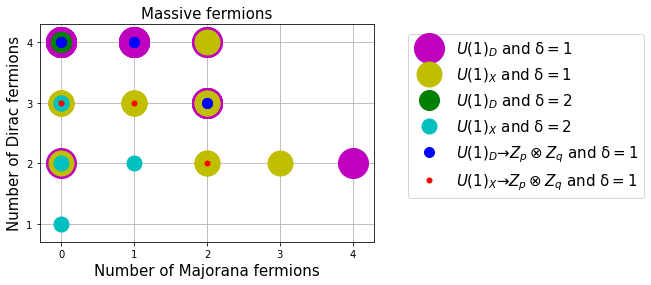

In [49]:
#https://stackoverflow.com/a/34880501
#Dark → δ=1
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.plot(df[ ( (df['active']==False) & (df['δ']==1) ) ]['majorana'],
         df[ ( (df['active']==False) & (df['δ']==1) ) ]['dirac'],'mo',markersize=30,label=r'$U(1)_D\ \rm{and}\ \delta=1$')
#Active → δ=1
ax.plot(df[ ( (df['active']==True) & (df['δ']==1) ) ]['majorana'],
         df[ ( (df['active']==True) & (df['δ']==1) ) ]['dirac'],'yo',markersize=25,label=r'$U(1)_X\ \rm{and}\ \delta=1$')
#Dark → δ=2
ax.plot(df[ ( (df['active']==False) & (df['δ']==2) ) ]['majorana'],
         df[ ( (df['active']==False) & (df['δ']==2) ) ]['dirac'],'go',markersize=20,label=r'$U(1)_D\ \rm{and}\ \delta=2$')
#Active → δ=2
ax.plot(df[ ( (df['active']==True) & (df['δ']==2) ) ]['majorana'],
         df[ ( (df['active']==True) & (df['δ']==2) ) ]['dirac'],'co',markersize=15,label=r'$U(1)_X\ \rm{and}\ \delta=2$')


#Dark → δ=1 → unconditional
ax.plot(df[ ( (df['active']==False) & (df['δ']==1) & (df['unconditional']==True) ) ]['majorana'],
         df[ ( (df['active']==False) & (df['δ']==1) & (df['unconditional']==True) ) ]['dirac'],'bo',
         markersize=10,label=r'$U(1)_D \to Z_p\otimes Z_q\ \rm{and}\ \delta=1$')
#Active → δ=1 → unconditional
ax.plot(df[ ( (df['active']==True) & (df['δ']==1) & (df['unconditional']==True) ) ]['majorana'],
         df[ ( (df['active']==True) & (df['δ']==1) & (df['unconditional']==True) ) ]['dirac'],'ro',
        markersize=5,label=r'$U(1)_X \to Z_p\otimes Z_q\ \rm{and}\ \delta=1$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel('Number of Majorana fermions',size=15)
ax.set_ylabel('Number of Dirac fermions',size=15)
ax.set_title('Massive fermions',fontsize=15)

ax.set_ylim(0.7,4.3)
ax.set_xlim(-0.3,4.3)
ax.grid()
ax.legend(loc=(1.1,0.2),fontsize=15)

In [74]:
def get_generations(row):
    l=list(row['extra_generations'])
    if l[0]:
        l[0]=l[0]+1
    if l[0]==0 and row['dirac']:
        l[0]=l[0]+1
    if l[1]:
        l[1]=l[1]+1
    if l[1]==0 and row['majorana']:
        l[1]=l[1]+1
    return tuple(l)

In [76]:
df['generations']=df.apply(get_generations,axis='columns')

In [77]:
df

,active,dirac,majorana,extra_generations,n,unconditional,δ,generations
0,False,2,0,"(0, 0)",6,False,1,"(1, 0)"
1,True,1,0,"(0, 0)",7,False,2,"(1, 0)"
2,True,2,0,"(0, 0)",9,False,1,"(1, 0)"
3,True,2,1,"(0, 0)",9,False,2,"(1, 1)"
4,True,2,0,"(0, 0)",9,False,2,"(1, 0)"
5,False,3,2,"(1, 1)",10,True,1,"(2, 2)"
6,False,4,0,"(1, 0)",10,False,1,"(2, 0)"
7,False,4,1,"(1, 0)",10,True,1,"(2, 1)"
8,False,4,2,"(1, 1)",10,False,1,"(2, 2)"
9,False,4,0,"(2, 0)",10,False,2,"(3, 0)"


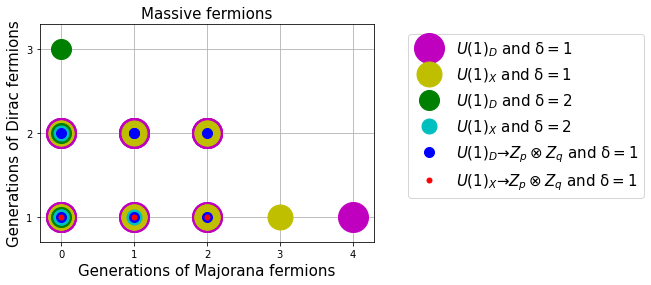

In [81]:
#https://stackoverflow.com/a/34880501
#Dark → δ=1
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.plot(df[ ( (df['active']==False) & (df['δ']==1) ) ]['generations'].str[1],
         df[ ( (df['active']==False) & (df['δ']==1) ) ]['generations'].str[0],'mo',markersize=30,label=r'$U(1)_D\ \rm{and}\ \delta=1$')
#Active → δ=1
ax.plot(df[ ( (df['active']==True) & (df['δ']==1) ) ]['generations'].str[1],
         df[ ( (df['active']==True) & (df['δ']==1) ) ]['generations'].str[0],'yo',markersize=25,label=r'$U(1)_X\ \rm{and}\ \delta=1$')
#Dark → δ=2
ax.plot(df[ ( (df['active']==False) & (df['δ']==2) ) ]['generations'].str[1],
         df[ ( (df['active']==False) & (df['δ']==2) ) ]['generations'].str[0],'go',markersize=20,label=r'$U(1)_D\ \rm{and}\ \delta=2$')
#Active → δ=2
ax.plot(df[ ( (df['active']==True) & (df['δ']==2) ) ]['generations'].str[1],
         df[ ( (df['active']==True) & (df['δ']==2) ) ]['generations'].str[0],'co',markersize=15,label=r'$U(1)_X\ \rm{and}\ \delta=2$')


#Dark → δ=1 → unconditional
ax.plot(df[ ( (df['active']==False) & (df['δ']==1) & (df['unconditional']==True) ) ]['generations'].str[1],
         df[ ( (df['active']==False) & (df['δ']==1) & (df['unconditional']==True) ) ]['generations'].str[0],'bo',
         markersize=10,label=r'$U(1)_D \to Z_p\otimes Z_q\ \rm{and}\ \delta=1$')
#Active → δ=1 → unconditional
ax.plot(df[ ( (df['active']==True) & (df['δ']==1) & (df['unconditional']==True) ) ]['generations'].str[1],
         df[ ( (df['active']==True) & (df['δ']==1) & (df['unconditional']==True) ) ]['generations'].str[0],'ro',
        markersize=5,label=r'$U(1)_X \to Z_p\otimes Z_q\ \rm{and}\ \delta=1$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel('Generations of Majorana fermions',size=15)
ax.set_ylabel('Generations of Dirac fermions',size=15)
ax.set_title('Massive fermions',fontsize=15)

ax.set_ylim(0.7,3.3)
ax.set_xlim(-0.3,4.3)
ax.grid()
ax.legend(loc=(1.1,0.2),fontsize=15)

In [40]:
df[ ( (df['active']==False) & (df['δ']==2) ) ]

,active,dirac,majorana,extra_generations,n,unconditional,δ
9,False,4,0,"(2, 0)",10,False,2
12,False,4,0,"(1, 0)",10,False,2
20,False,4,0,"(0, 0)",10,False,2
